# Поиск изображений по описанию

Задача: разработать Proof of Concept версию поиска изображений по запросу.

Модель должна на входе получать эмбединги изображения и запроса, а на выходе предоставлять значение от 0 до 1 - вероятность соответствия запроса и изображению.

Обычно эта задача решается кодированием одного эмбединга в другой (напр. эмбединга картинки в эмбединг запроса), по которому происходит поиск с помощью измерения расстояния между векторами и поиска наиболее близких.

**Как собирались данные?**

Экспертам и крауду были показаны изображения и их описания. Часть описаний соответствовало изображениям, часть - нет.

3 эксперта каждый выставляли оценку от 1 до 4, где   
* 1 — изображение и запрос совершенно не соответствуют друг другу,   
* 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,   
* 3 — запрос и текст соответствуют с точностью до некоторых деталей,   
* 4 — запрос и текст соответствуют полностью.

Оценки крауда включают в себя:
* Доля людей, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание не соответствует изображению.

**Дополнительное условие:**  
Необходимо исключить из обучающей выборки изображения детей младше 16 лет.

А при попытке найти такие изображения вместо картинок должен показываться дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 


## Импорты

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import mean_squared_error

from sentence_transformers import SentenceTransformer, util

from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from torchvision import transforms

from tqdm import tqdm

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit 

from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
import optuna

C:\Users\SnakeRZR\Desktop\projects\general_study\env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Описание и загрузка данных

Данные лежат в папке `/datasets/image_search/` или `data/`.

* `train_dataset.csv`
* `train_images/...`
* `CrowdAnnotations.tsv`
* `ExpertAnnotations.tsv`
* `test_queries.csv`
* `test_images/...`

Подробное описание данных будет дальше.

In [3]:
PATH = 'data/'
PATH_TRAIN_IMAGES = 'data/train_images/' 
PATH_TEST_IMAGES = 'data/test_images/'

In [4]:
train_dataset = pd.read_csv(PATH+'train_dataset.csv')

crowd_annotations = pd.read_csv(PATH+'CrowdAnnotations.tsv',
                                sep='\t',
                                names=['image','query_id','pos_freq','pos_count','neg_count'])

expert_annotations = pd.read_csv(PATH+'ExpertAnnotations.tsv',
                                 sep='\t',
                                 names=['image','query_id','r_1','r_2','r_3'])

test_queries = pd.read_csv(PATH+'test_queries.csv',
                           sep='|',
                           index_col=0)

#### train_dataset.csv

В файле `train_dataset.csv` находится информация, необходимая для обучения:   
имя файла изображения,   
идентификатор описания и   
текст описания.   

Для одной картинки может быть доступно до 5 описаний. 

Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [5]:
train_dataset.head(3)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...

Видим, что некоторые `query_id` и `query_text` принадлежат к другому `image`.   
Напр. строка 0, `image` == `1056338697_4f7d7ce270.jpg`, а `query_id` == `2549968784_39bfbe44f9.jpg#2`.

Здесь дело в том, что экспертам и крауду давались описания других картинок тоже, поэтому у картинки `1056338697_4f7d7ce270.jpg` описание `2549968784_39bfbe44f9.jpg#2`. Чтобы у экспертов и крауда были варианты, в которых описание не совпадает с картинкой.

In [6]:
train_dataset.tail(3)

image                     query_id  \
5819  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                        query_text  
5819  A dog stands on the side of a grassy cliff .  
5820                  A blurry photo of two dogs .  
5821                   A man rows his boat below .

In [7]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


#### train_images/...

В папке `train_images` содержатся изображения для тренировки модели.

In [8]:
os.listdir(PATH_TRAIN_IMAGES)[:5]

['1056338697_4f7d7ce270.jpg',
 '106490881_5a2dd9b7bd.jpg',
 '1082379191_ec1e53f996.jpg',
 '1084040636_97d9633581.jpg',
 '1096395242_fc69f0ae5a.jpg']

In [9]:
print('Кол-во файлов в папке train_images:',len(os.listdir(PATH_TRAIN_IMAGES)))

Кол-во файлов в папке train_images: 1000


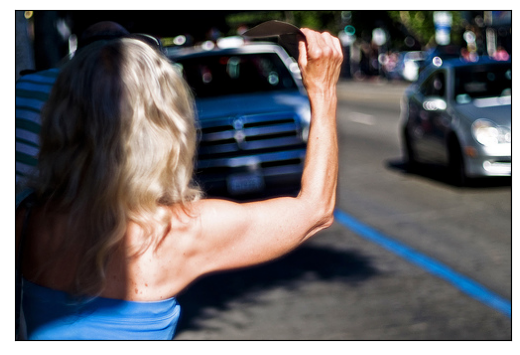

In [10]:
img = mpimg.imread(PATH_TRAIN_IMAGES + '1056338697_4f7d7ce270.jpg')
_ = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

#### crowd_annotations

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [11]:
crowd_annotations.head(3)

image                     query_id  pos_freq  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2       1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2       0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2       0.0   

   pos_count  neg_count  
0          3          0  
1          0          3  
2          0          3

In [12]:
crowd_annotations.tail(3)

image                    query_id  pos_freq  \
47827  997722733_0cb5439472.jpg  872622575_ba1d3632cc.jpg#2  1.000000   
47828  997722733_0cb5439472.jpg  888425986_e4b6c12324.jpg#2  0.000000   
47829  997722733_0cb5439472.jpg  997722733_0cb5439472.jpg#2  0.666667   

       pos_count  neg_count  
47827          3          0  
47828          0          3  
47829          2          1

In [13]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   pos_freq   47830 non-null  float64
 3   pos_count  47830 non-null  int64  
 4   neg_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


#### expert_annotations

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где  
1 — изображение и запрос совершенно не соответствуют друг другу,  
2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,  
3 — запрос и текст соответствуют с точностью до некоторых деталей,  
4 — запрос и текст соответствуют полностью.

In [14]:
expert_annotations.head(3)

image                     query_id  r_1  r_2  r_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2    1    1    1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2    1    1    2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2    1    1    2

In [15]:
expert_annotations.tail(3)

image                     query_id  r_1  r_2  r_3
5819  997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2    1    1    2
5820  997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2    1    1    1
5821  997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2    3    3    3

In [16]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   r_1       5822 non-null   int64 
 3   r_2       5822 non-null   int64 
 4   r_3       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


#### test_queries

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

In [17]:
test_queries.head(3)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg

In [18]:
test_queries.tail(3)

query_id  \
497  989851184_9ef368e520.jpg#2   
498  989851184_9ef368e520.jpg#3   
499  989851184_9ef368e520.jpg#4   

                                            query_text  \
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                        image  
497  989851184_9ef368e520.jpg  
498  989851184_9ef368e520.jpg  
499  989851184_9ef368e520.jpg

In [19]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


#### test_images/...

В папке `test_images` содержатся изображения для тестирования модели.

In [20]:
os.listdir(PATH_TEST_IMAGES)[:5]

['1177994172_10d143cb8d.jpg',
 '1232148178_4f45cc3284.jpg',
 '123997871_6a9ca987b1.jpg',
 '1319634306_816f21677f.jpg',
 '1429546659_44cb09cbe2.jpg']

In [21]:
print('Кол-во файлов в папке test_images:',len(os.listdir(PATH_TEST_IMAGES)))

Кол-во файлов в папке test_images: 100


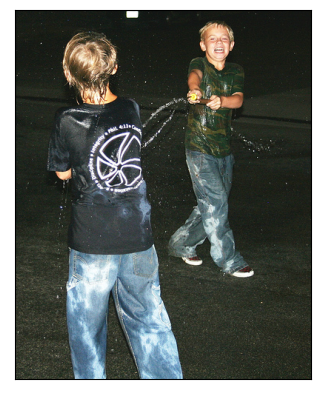

In [22]:
img = mpimg.imread(PATH_TEST_IMAGES + '1177994172_10d143cb8d.jpg')
_ = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

## Исследовательский анализ данных

Объединим данные в 1 датафрейм.

In [23]:
ratings = expert_annotations.merge(crowd_annotations,on=['image','query_id'])

In [24]:
train_dataset = train_dataset.merge(ratings,on=['image','query_id'])

In [25]:
train_dataset

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3     3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4     3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
2324   476759700_8911f087f8.jpg  1082379191_ec1e53f996.jpg#2   
2325   561417861_8e25d0c0e8.jpg   410453140_5401bf659a.jpg#2   
2326   561940436_64d6fc125d.jpg  3157847991_463e006a28.jpg#2   
2327   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
2328   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   

                                             query_text  r_1  r_2  r_3  \
0     A young child is wearing blue goggles and sitt...    1    1    1   
1     A young child is wearing blue goggles and sitt...    1    2    2   
2     A young child is wearing blue goggles and sitt...    4    4    4   
3     A young child is wearing blue goggles and sitt...    2    2    3   
4     A young child is wearing blue goggles and sitt...    1    1    1   
...                                                 ...  ...  ...  ...   
2324              A man and a woman sitting on a dock .    1    1    2   
2325  A man stands at the entrance of Yerba Buena Ce...    2    2    2   
2326  Two men in black jackets behind a white handra...    1    1    2   
2327         A man in an ampitheater talking to a boy .    2    2    3   
2328                       A blurry photo of two dogs .    2    3    3   

      pos_freq  pos_count  neg_count  
0     0.000000          0          3  
1     0.000000          0          3  
2     1.000000          3          0  
3     0.000000          0          3  
4     0.000000          0          3  
...        ...        ...        ...  
2324  0.000000          0          3  
2325  0.000000          0          3  
2326  0.000000          0          3  
2327  0.333333          1          2  
2328  0.000000          0          3  

[2329 rows x 9 columns]

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения. Необходимо агрегировать эти оценки в одну, чтобы получить число в от 0 до 1, описывающую вероятность соответствия изображения описанию.

Суммируем оценки экспертов и мин-максим до диапазона от 0 до 1.

In [26]:
train_dataset['target'] = train_dataset[['r_1','r_2','r_3']].sum(axis=1)

min_max_scaler = MinMaxScaler()
train_dataset['target'] = min_max_scaler.fit_transform(train_dataset[['target']])

In [27]:
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
3  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
4  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  r_1  r_2  r_3  pos_freq  \
0  A young child is wearing blue goggles and sitt...    1    1    1       0.0   
1  A young child is wearing blue goggles and sitt...    1    2    2       0.0   
2  A young child is wearing blue goggles and sitt...    4    4    4       1.0   
3  A young child is wearing blue goggles and sitt...    2    2    3       0.0   
4  A young child is wearing blue goggles and sitt...    1    1    1       0.0   

   pos_count  neg_count    target  
0          0          3  0.000000  
1          0          3  0.222222  
2          3          0  1.000000  
3          0          3  0.444444  
4          0          3  0.000000

Дропнем лишние столбцы.

In [28]:
train_dataset = train_dataset[['image','query_text','target']]

In [29]:
train_dataset

image  \
0     1056338697_4f7d7ce270.jpg   
1     2447284966_d6bbdb4b6e.jpg   
2     2549968784_39bfbe44f9.jpg   
3     3030566410_393c36a6c5.jpg   
4     3718964174_cb2dc1615e.jpg   
...                         ...   
2324   476759700_8911f087f8.jpg   
2325   561417861_8e25d0c0e8.jpg   
2326   561940436_64d6fc125d.jpg   
2327   757046028_ff5999f91b.jpg   
2328   929679367_ff8c7df2ee.jpg   

                                             query_text    target  
0     A young child is wearing blue goggles and sitt...  0.000000  
1     A young child is wearing blue goggles and sitt...  0.222222  
2     A young child is wearing blue goggles and sitt...  1.000000  
3     A young child is wearing blue goggles and sitt...  0.444444  
4     A young child is wearing blue goggles and sitt...  0.000000  
...                                                 ...       ...  
2324              A man and a woman sitting on a dock .  0.111111  
2325  A man stands at the entrance of Yerba Buena Ce...  0.333333  
2326  Two men in black jackets behind a white handra...  0.111111  
2327         A man in an ampitheater talking to a boy .  0.444444  
2328                       A blurry photo of two dogs .  0.555556  

[2329 rows x 3 columns]

## Проверка данных

Отфильтруем слова `'child','girl','boy','kid'`.

In [30]:
stop_words = ['child','girl','boy','kid']

In [31]:
for word in stop_words:
    train_dataset['contains_'+word] = train_dataset['query_text'].str.contains(word)
    # break

C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_13044\2001265645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['contains_'+word] = train_dataset['query_text'].str.contains(word)
C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_13044\2001265645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['contains_'+word] = train_dataset['query_text'].str.contains(word)
C:\Users\SnakeRZR\AppData\Local\Temp\ipykernel_13044\2001265645.py:2: SettingWithCopyWarning: 
A value is trying to be

In [32]:
mask = (train_dataset['contains_child']==True)|(train_dataset['contains_girl']==True)|(train_dataset['contains_boy']==True)|(train_dataset['contains_kid']==True)
train_dataset.loc[~mask]

image  \
12     463978865_c87c6ca84c.jpg   
13     370713359_7560808550.jpg   
14    1962729184_6996e128e7.jpg   
15    2101457132_69c950bc45.jpg   
16    2351479551_e8820a1ff3.jpg   
...                         ...   
2322   415793623_6c1225ae27.jpg   
2324   476759700_8911f087f8.jpg   
2325   561417861_8e25d0c0e8.jpg   
2326   561940436_64d6fc125d.jpg   
2328   929679367_ff8c7df2ee.jpg   

                                             query_text    target  \
12      A man sleeps under a blanket on a city street .  0.333333   
13    A woman plays with long red ribbons in an empt...  0.000000   
14           Chinese market street in the winter time .  0.333333   
15           Chinese market street in the winter time .  0.000000   
16    A soccer ball is above the head of a man weari...  0.111111   
...                                                 ...       ...   
2322  a man wearing a yellow shirt and white hardhat...  0.222222   
2324              A man and a woman sitting on a dock .  0.111111   
2325  A man stands at the entrance of Yerba Buena Ce...  0.333333   
2326  Two men in black jackets behind a white handra...  0.111111   
2328                       A blurry photo of two dogs .  0.555556   

      contains_child  contains_girl  contains_boy  contains_kid  
12             False          False         False         False  
13             False          False         False         False  
14             False          False         False         False  
15             False          False         False         False  
16             False          False         False         False  
...              ...            ...           ...           ...  
2322           False          False         False         False  
2324           False          False         False         False  
2325           False          False         False         False  
2326           False          False         False         False  
2328           False          False         False         False  

[1835 rows x 7 columns]

In [33]:
train_dataset = train_dataset.loc[~mask].reset_index(drop=True)

## Векторизация изображений

Закодируем изображения с помощью `resnet50`.

In [34]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
print('done')

Using cache found in C:\Users\SnakeRZR/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\SnakeRZR\Desktop\projects\general_study\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\SnakeRZR\Desktop\projects\general_study\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


In [35]:
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
resnet.eval()
print('done')

done


In [36]:
resnet.to(device)
print('done')

done


In [37]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [38]:
image_embedings = torch.Tensor().to(device)

for image_name in train_dataset['image'].values:
    file_name = PATH_TRAIN_IMAGES + image_name
    input_image = Image.open(file_name)
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = resnet(input_batch)
        
    image_embedings = torch.cat((image_embedings,torch.reshape(output,(1,2048))))
    

In [39]:
image_embedings.shape

torch.Size([1835, 2048])

In [40]:
image_embedings = image_embedings.cpu().numpy()

In [41]:
pd.DataFrame(image_embedings).head(2)

0         1         2         3         4         5         6     \
0  0.290221  0.670144  0.086188  1.115604  0.367675  0.208048  0.646783   
1  0.550451  0.755183  0.806311  0.405546  1.371212  0.531481  0.393299   

       7         8         9     ...      2038      2039      2040      2041  \
0  0.315416  0.139132  1.334324  ...  0.294715  0.405343  0.097435  0.132927   
1  0.527206  0.251665  0.244670  ...  0.546624  0.153096  0.606502  0.551150   

       2042      2043      2044      2045      2046      2047  
0  0.153024  0.502080  0.302911  0.074501  0.070591  0.327466  
1  0.095192  0.255252  0.427488  0.427000  0.696896  0.304350  

[2 rows x 2048 columns]

## Векторизация текстов

Создадим эмбединги с помощью `sentence-transformers/bert-base-nli-max-tokens`.


In [42]:
sbert = SentenceTransformer('bert-base-nli-mean-tokens',device=device)

In [43]:
sentence_embedings = sbert.encode(train_dataset['query_text'].values)

In [44]:
sentence_embedings.shape

(1835, 768)

## Объединение векторов

In [45]:
X = np.concatenate([image_embedings,sentence_embedings],axis=1)
X.shape

(1835, 2816)

In [46]:
y = train_dataset['target'].values
y.shape

(1835,)

## Обучение модели предсказания соответствия

Воспользуемся `GroupShuffleSplit` для разделения датасетя на тренировочную и тестовую выборку, чтобы исключить попадание картинок в обе выборки.

In [47]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_dataset['image']))
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[test_indices], y[test_indices]

Нам нужно получать вероятность, с которой картинка соответствует описанию.   
Поскольку таргетом является тоже вероятность (от 0 до 1), а не конкретная принадлежность к классу (0 или 1), то задачу стоит рассматривать, как **задачу регрессии**, где в конце мы получаем эту вероятность.  
Метрику качества используем среднюю квадратичную ошибку.

Проверим работу линейной регрессии и нейронной сети.

В нейронной сети, чтобы получить такое число используем ф-цию активации `nn.Sigmoid`, а метрикой качества будет средняя квадратичная ошибка `nn.MSELoss`.

**Линейная модель**

Убедимся, что линейная модель здесь не подходит.

In [55]:
lin_reg = LinearRegression()

lin_reg_cv = cross_val_score(lin_reg,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

In [56]:
abs(lin_reg_cv.mean())

1132.945792059229

In [60]:
pd.DataFrame(lin_reg_cv,columns=['neg_MSE'])

neg_MSE
0    -1.124408
1    -0.725344
2    -0.352589
3 -5662.161987
4    -0.364633

Очень нестабильная модель.

**Нейронная сеть**

In [48]:
class CustomDataset(Dataset):
    
    def __init__(self,X,y):
        self.features = X
        self.target = y
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        X = self.features[idx]
        y = self.target[idx]
        return X,y
    
dataset_train = CustomDataset(X_train,y_train)
dataset_val = CustomDataset(X_val, y_val)

train_dataloader = DataLoader(dataset_train, batch_size=32,shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=32,shuffle=False)

In [49]:
class Baseline(nn.Module):
    
    def __init__(self,
                 n_in,n_2,n_3,n_4,n_5,n_out,
                activation_1,
                activation_2,
                activation_3,
                activation_4):
        
        super(Baseline,self).__init__()
            
        self.f1 = nn.Linear(n_in,n_2)
        self.a1 = activation_1
        
        self.f2 = nn.Linear(n_2,n_3)
        self.a2 = activation_2
        
        self.f3 = nn.Linear(n_3,n_4)
        self.a3 = activation_3
        
        self.f4 = nn.Linear(n_4,n_5)
        self.a4 = activation_4
        
        self.f5 = nn.Linear(n_5,n_out)
        self.a5 = nn.Sigmoid()
        
        self.init_weights()
        
    def forward(self, x):
        x = self.a1(self.f1(x))
        x = self.a2(self.f2(x))
        x = self.a3(self.f3(x))
        x = self.a4(self.f4(x))
        x = self.a5(self.f5(x))
        return x
    
    def init_weights(m):
        if isinstance(m,nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

In [50]:
writer_train = SummaryWriter(log_dir='runs/train_baseline')
writer_test = SummaryWriter(log_dir='runs/test_baseline')

In [51]:
def model_forward(model,train_dataloader,eval_dataloader,loss_fn,optimizer,steps=500):
    
    model.to(device)
    
    
    with tqdm(total=steps) as pbar:
        
        for step in range(steps):
            model.train()
            
            total_loss = []
            
            for X,y in train_dataloader:
                X = X.to(device).float()
                y_true = y.to(device).float().unsqueeze(1)
  
                y_pred = model(X)

                loss = loss_fn(y_pred,y_true)
                
                optimizer.zero_grad()
                
                loss.backward()
                
                optimizer.step()
                
                total_loss.append(loss.item())
                
            writer_train.add_scalar('loss',sum(total_loss)/len(train_dataloader), step)
    
            model.eval()
            
            total_eval_loss = []
            with torch.inference_mode():
                for X,y in eval_dataloader:
                    X = X.to(device).float()
                    y_true = y.to(device).float().unsqueeze(1)

                    eval_pred = model(X)

                    eval_loss = loss_fn(eval_pred,y_true)
                    
                    total_eval_loss.append(eval_loss.item())
                    
            writer_test.add_scalar('loss', sum(total_eval_loss)/len(eval_dataloader), step)
                    
            pbar.update(1)
            pbar.set_description(f'train_loss: {loss.item():.4f}, val_loss: {eval_loss.item():.4f}')

In [52]:
n_in, n_2, n_3, n_4, n_5, n_out = X_train.shape[-1], 2000, 500, 200, 100, 1

activation1, activation2, activation3, activation4 = nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()

loss_fn = nn.MSELoss()
model_base = Baseline(n_in, n_2, n_3, n_4, n_5, n_out, activation1, activation2, activation3, activation4)
optimizer = torch.optim.Adam(model_base.parameters(), lr = 1e-5)
model_base.to(device)

model_forward(model_base,train_dataloader,val_dataloader,loss_fn,optimizer,1000)

train_loss: 0.0009, val_loss: 0.0628: 100%|████████████████████████████████████████| 1000/1000 [05:06<00:00,  3.26it/s]


In [53]:
%load_ext tensorboard

In [54]:
# %reload_ext tensorboard

In [55]:
%tensorboard --logdir=runs

## Тестирование модели

Для тестирования модели:
1. Создать эмбединги всех тестовых изображений из папки `test_images`
2. Выбрать случайных 10 запросов из `test_queries.csv`
3. Для каждого запроса вывести подходящее изображение.

In [59]:
test_queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

In [60]:
test_images_embedings = torch.Tensor().to(device)


for image_name in test_queries['image'].unique():
    file_name = PATH_TEST_IMAGES + image_name
    input_image = Image.open(file_name)
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = resnet(input_batch)
        
    test_images_embedings = torch.cat((test_images_embedings,torch.reshape(output,(1,2048))))
    

In [61]:
test_images_embedings = test_images_embedings.detach().cpu().numpy()

In [62]:
test_queries['image'].unique().shape

(100,)

In [63]:
test_images_embedings.shape

(100, 2048)

In [64]:
def return_image(query,model,test_images_embedings,sbert):
    
    if any(stop_word in query for stop_word in stop_words):
        print('This image is unavailable in your country in compliance with local laws.')
        return None
    
    model.eval()
    
    query_embeding = sbert.encode(query)
    # print(query_embeding.shape)
    
    query_embeding = np.tile(query_embeding,(100,1))
    # print(query_embeding.shape)
    
    tie_plus_query = np.concatenate((test_images_embedings,query_embeding),axis=1)
    
    tie_plus_query = torch.Tensor(tie_plus_query).to(device)
    
    output = model.forward(tie_plus_query)
    image_id = output.argmax()
    
    image_name = test_queries['image'].unique()[image_id.detach().cpu().numpy()]
    
    
    # print(query)
    img = mpimg.imread(PATH_TEST_IMAGES + image_name)
    _ = plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return image_id

Query: A little girl leans over the side of a wall to feed ducks in the water .
This image is unavailable in your country in compliance with local laws.

Query: A man on an orange bike .


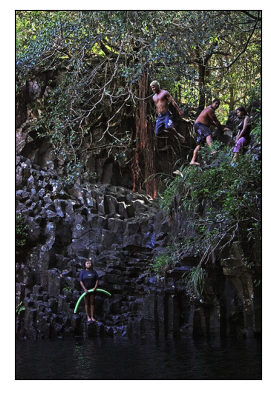


Query: Two people in a tent near a rock wall .


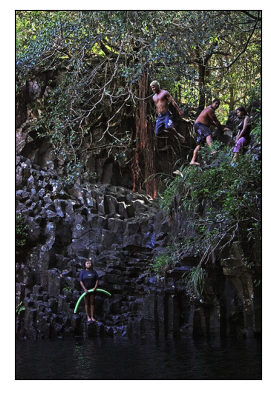


Query: Two women dressed with scarves over their heads look angrily at the photographer .


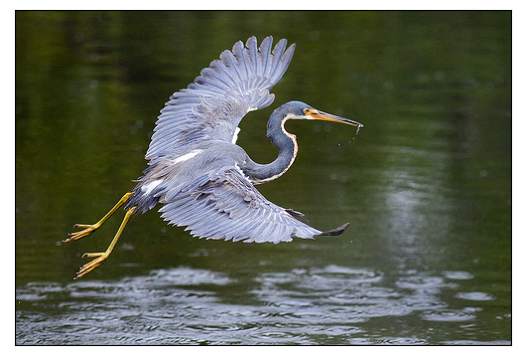


Query: A boy in a blue shirt and white helmet is riding a white bike .
This image is unavailable in your country in compliance with local laws.

Query: Men in a khaki-colored tent outside in a rundown area .


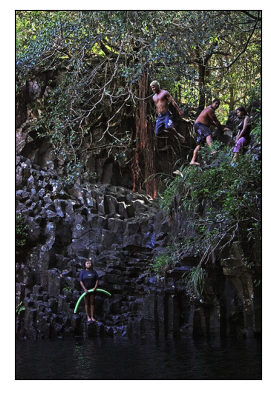


Query: A black and white dog with a green collar stands in front of a sign .


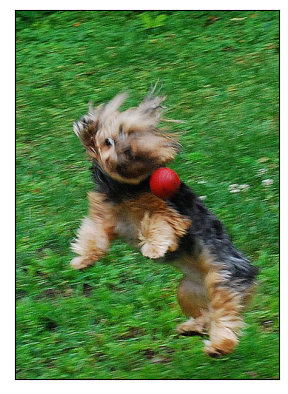


Query: A three legged black and white dog running behind a brown dog with a red bandanna .


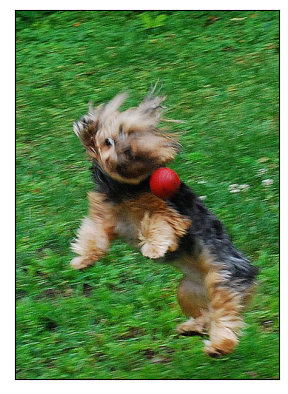


Query: A black and white dog jumping out of the water and a brown dog shaking off .


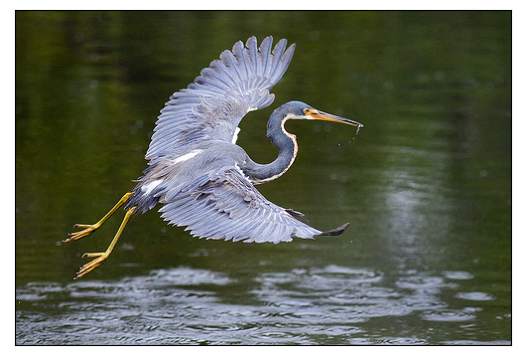


Query: People skate in an urban outdoor ice skating rink


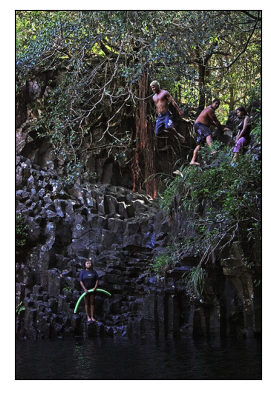

In [65]:
for query in test_queries['query_text'].sample(10):
    print('Query:', query)
    return_image(query,model_base,test_images_embedings,sbert)
    print()

## Проверим предобученную модель Open AI CLIP

In [66]:
images_lst = []

for image_name in test_queries['image'].unique():
    file_name = PATH_TEST_IMAGES + image_name
    input_image = Image.open(file_name)
    images_lst.append(input_image)
    
#Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

#Encode an image:
img_emb = model.encode(images_lst)

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [67]:
img_emb.shape

(100, 512)

In [68]:
def return_image(query,model,test_images_embedings):
    
    if any(stop_word in query for stop_word in stop_words):
        print('This image is unavailable in your country in compliance with local laws.')
        return None
    
    query_embeding = model.encode(query)
    
    cos_scores = util.cos_sim(img_emb, query_embeding)
    
    image_id = cos_scores.argmax()
    
    image_name = test_queries['image'].unique()[image_id.detach().cpu().numpy()]
    
    
    # print(query)
    img = mpimg.imread(PATH_TEST_IMAGES + image_name)
    _ = plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return image_name

# return_image(test_queries['query_text'][87],model,img_emb)

Query: A dog in a harness pulling a pink carrier behind it on snow .


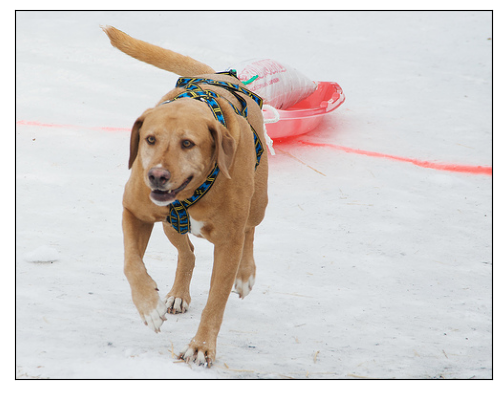


Query: A man in a flowered bathing suit waterskies on one ski while being pulled by a rope .


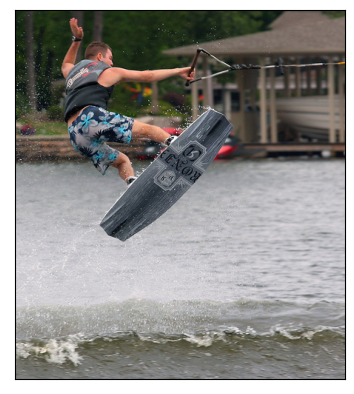


Query: two people sit on a park bench .



Query: Two boys playing in water .
This image is unavailable in your country in compliance with local laws.

Query: A group of six men stand in a circle playing instruments in a wooded parking lot .


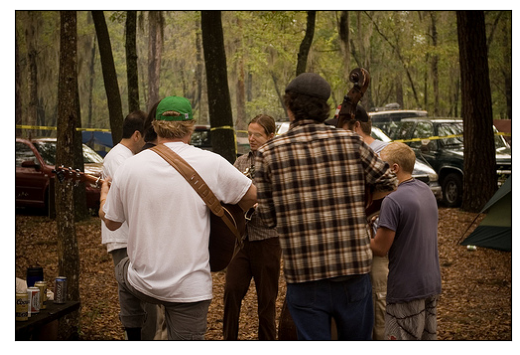


Query: A dog is jumping into a pool for a swim competition


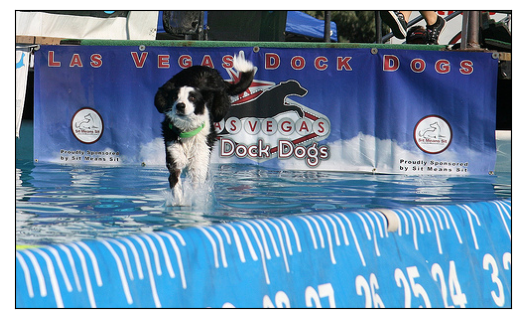


Query: A large tan dog sits on a grassy hill .


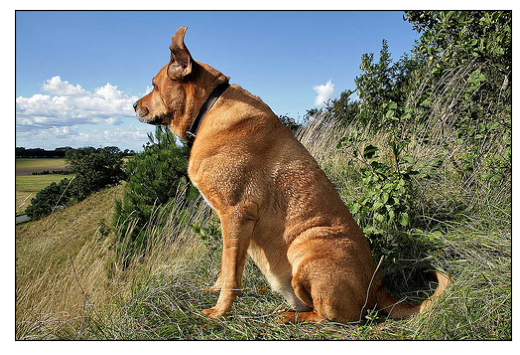


Query: Four young people with cold drinks stand on the sidewalk in front of cartoon cutouts of the Simpsons also holding cold drinks .


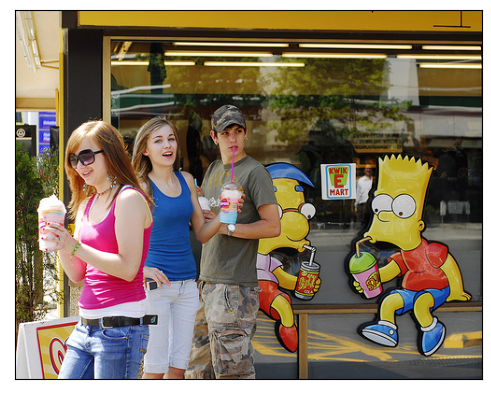


Query: A boy and a girl at the beach , throwing sand .
This image is unavailable in your country in compliance with local laws.

Query: A man is jumping his bicycle off of a ramp .


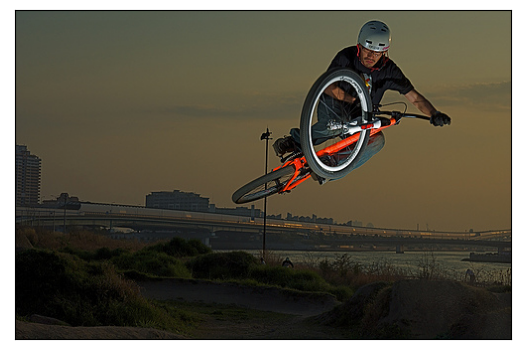

In [69]:
for query in test_queries['query_text'].sample(10):
    print('Query:', query)
    return_image(query,model,img_emb)
    print()

## Выводы


В качестве вводных данных были дадены пары картинка+описание, по которым эксперты и крауд проводили оценку соответствия. В качестве таргета было принято решение использовать сумму оценок экспертов, преобразованную в диапазон от 0 до 1.

Для машинного обучения была определена задача регрессии, т.к. необходимо было получить вероятность соответствия описания картинки в том же виде, что и таргет (от 0 до 1). А в качестве метрики использовали среднюю квадратичную ошибку.

Сравнили 3 модели:
- Линейную регрессию, которая проявила себя очень нестабильно на этих данных, судя исключительно по метрике на кросс валидации.
- Нейронную сеть из 5 слоев, для которой объективно не хватало данных, а loss на валидации не удалось опустить ниже 0.05 MSE или 0.25 RMSE, что можно интерпретировать как погрешность оценки в 25% - это довольно много.
- Преобученную модель `Open AI CLIP`, которая дала наилучшие результаты, близкие к 100% совпадению.